In [56]:
import numpy as np
import pandas as pd

In [57]:
train = pd.read_csv("../../../train-metadata.csv")
test = pd.read_csv("../../../test-metadata.csv")

C:\Users\efim6\AppData\Local\Temp\ipykernel_21436\1523111444.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("../../../train-metadata.csv")


In [58]:
train.shape

(401059, 55)

In [59]:
y = train["target"]

In [60]:
test.shape

(3, 44)

Test has fewer columns than train - only use the intersection so that we can apply to test data <br>

In [61]:
shared_cols = set(train.columns).intersection(set(test.columns))
len(shared_cols)

44

Use second line in the next cell if you want to use all columns instead.

In [62]:
train_trim = train[list(shared_cols)]
# train_trim = train 
train_trim.shape

(401059, 44)

String columns

In [63]:
len(train_trim.select_dtypes(include="object").columns)

10

Number columns

In [64]:
len(train_trim.select_dtypes(include="number").columns)

34

Null checking

In [65]:
nulls = train_trim.apply(lambda col: col.isnull().sum() / col.size * 100)
nulls.head()

isic_id                    0.000000
tbp_lv_location            0.000000
tbp_lv_area_perim_ratio    0.000000
sex                        2.871647
tbp_lv_deltaA              0.000000
dtype: float64

Columns with nulls

In [66]:
nulls[nulls > 0]

sex                    2.871647
anatom_site_general    1.435200
age_approx             0.697653
dtype: float64

Dropping rows with null age. Sex handled later, anatom_site_general not used.

In [67]:
train_trim = train_trim.dropna(subset=['age_approx'])

Extract string columns

In [68]:
string_cols = train_trim.select_dtypes(include="object")
string_cols.head()

,isic_id,tbp_lv_location,sex,tbp_tile_type,image_type,attribution,copyright_license,tbp_lv_location_simple,patient_id,anatom_site_general
0,ISIC_0015670,Right Leg - Upper,male,3D: white,TBP tile: close-up,Memorial Sloan Kettering Cancer Center,CC-BY,Right Leg,IP_1235828,lower extremity
1,ISIC_0015845,Head & Neck,male,3D: white,TBP tile: close-up,Memorial Sloan Kettering Cancer Center,CC-BY,Head & Neck,IP_8170065,head/neck
2,ISIC_0015864,Torso Back Top Third,male,3D: XP,TBP tile: close-up,Memorial Sloan Kettering Cancer Center,CC-BY,Torso Back,IP_6724798,posterior torso
3,ISIC_0015902,Torso Front Top Half,male,3D: XP,TBP tile: close-up,ACEMID MIA,CC-0,Torso Front,IP_4111386,anterior torso
4,ISIC_0024200,Torso Front Top Half,male,3D: white,TBP tile: close-up,Memorial Sloan Kettering Cancer Center,CC-BY,Torso Front,IP_8313778,anterior torso


Check for constant-value columns

In [69]:
string_cols.apply(lambda row: row.unique())

isic_id                   [ISIC_0015670, ISIC_0015845, ISIC_0015864, ISI...
tbp_lv_location           [Right Leg - Upper, Head & Neck, Torso Back To...
sex                                                     [male, female, nan]
tbp_tile_type                                           [3D: white, 3D: XP]
image_type                                             [TBP tile: close-up]
attribution               [Memorial Sloan Kettering Cancer Center, ACEMI...
copyright_license                                   [CC-BY, CC-0, CC-BY-NC]
tbp_lv_location_simple    [Right Leg, Head & Neck, Torso Back, Torso Fro...
patient_id                [IP_1235828, IP_8170065, IP_6724798, IP_411138...
anatom_site_general       [lower extremity, head/neck, posterior torso, ...
dtype: object

Drop ID and other useless string columns

In [70]:
to_drop = ["tbp_tile_type", "copyright_license", "isic_id", "patient_id", "attribution", "image_type"]
set(string_cols.columns).difference(set(to_drop))

{'anatom_site_general', 'sex', 'tbp_lv_location', 'tbp_lv_location_simple'}

3 location columns, increasing specificity. Using the middle one for one-hot encoding

In [71]:
string_cols["anatom_site_general"].value_counts()

anatom_site_general
posterior torso    121143
lower extremity    102071
anterior torso      87256
upper extremity     70088
head/neck           11962
Name: count, dtype: int64

In [72]:
string_cols["tbp_lv_location_simple"].value_counts()

tbp_lv_location_simple
Torso Back     121143
Torso Front     87256
Left Leg        52633
Right Leg       49438
Left Arm        36124
Right Arm       33964
Head & Neck     11962
Unknown          5741
Name: count, dtype: int64

In [73]:
string_cols["tbp_lv_location"].value_counts()

tbp_lv_location
Torso Back Top Third       70703
Torso Front Top Half       62991
Torso Back Middle Third    45859
Left Leg - Lower           27205
Right Leg - Lower          25008
Torso Front Bottom Half    24205
Left Leg - Upper           23454
Right Arm - Upper          22849
Right Leg - Upper          22719
Left Arm - Upper           22713
Head & Neck                11962
Left Arm - Lower           11820
Right Arm - Lower          10514
Unknown                     5741
Torso Back Bottom Third     4572
Left Leg                    1974
Right Leg                   1711
Left Arm                    1591
Right Arm                    601
Torso Front                   60
Torso Back                     9
Name: count, dtype: int64

One-hot encoding the sex column. Using a vector of length 2 here to account for the NaaNs - when the value is "unknown", the vector is [0, 0]. Alternatively, we could drop all NaaN rows and use a single indicator column.

In [74]:
male_indicator = string_cols["sex"].apply(lambda s: int(s == "male" and not s == "unknown"))
male_indicator.name = "Male"
female_indicator = string_cols["sex"].apply(lambda s: int(s == "female" and not s == "unknown"))
female_indicator.name = "Female"

In [75]:
numerical_sex = pd.concat([male_indicator, female_indicator], axis=1)
numerical_sex.tail()

,Male,Female
401054,1,0
401055,1,0
401056,0,1
401057,0,1
401058,1,0


One-hot encoding the location column

In [76]:
one_hot_location = pd.Series(string_cols["tbp_lv_location_simple"].value_counts().index[:-1]).apply(
    lambda location: string_cols["tbp_lv_location_simple"].apply(lambda loc: int(loc == location))).transpose()
one_hot_location.columns = string_cols["tbp_lv_location_simple"].value_counts().index[:-1]
one_hot_location.head()


tbp_lv_location_simple,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


Total one-hot encoded columns

In [77]:
one_hot_combined = pd.concat([numerical_sex, one_hot_location], axis=1)
one_hot_combined.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck
0,1,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,1
2,1,0,1,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0


Normalizing other numerical columns to the [0, 1] range with min-max scaling

In [78]:
numerical = train_trim.select_dtypes(include="number")

for column in numerical.columns: 
    numerical[column] = (numerical[column] - numerical[column].min()) / (numerical[column].max() - numerical[column].min())     

Concat with numerical columns to get the clean data

In [79]:
clean = pd.concat([one_hot_combined, numerical], axis=1)
clean.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck,tbp_lv_area_perim_ratio,...,tbp_lv_Bext,tbp_lv_z,tbp_lv_Aext,tbp_lv_Hext,tbp_lv_perimeterMM,tbp_lv_x,tbp_lv_B,tbp_lv_H,age_approx,tbp_lv_symm_2axis
0,1,0,0,0,0,1,0,0,0,0.218652,...,0.376069,0.408087,0.549700,0.267121,0.067335,0.356776,0.502444,0.508448,0.6875,0.582086
1,1,0,0,0,0,0,0,0,1,0.019278,...,0.391260,0.571023,0.747149,0.152394,0.007756,0.504132,0.491697,0.384152,0.6875,0.252621
2,1,0,1,0,0,0,0,0,0,0.175593,...,0.619598,0.858501,0.568489,0.336171,0.063125,0.603966,0.703178,0.566217,0.6875,0.334987
3,1,0,0,1,0,0,0,0,0,0.053995,...,0.303669,0.572962,0.460827,0.308385,0.069412,0.390405,0.402979,0.539680,0.7500,0.170317
4,1,0,0,1,0,0,0,0,0,0.119577,...,0.420931,0.512548,0.632028,0.230185,0.038916,0.445845,0.494130,0.451561,0.6250,0.282586


In [80]:
clean.columns

Index(['Male', 'Female', 'Torso Back', 'Torso Front', 'Left Leg', 'Right Leg',
       'Left Arm', 'Right Arm', 'Head & Neck', 'tbp_lv_area_perim_ratio',
       'tbp_lv_deltaA', 'tbp_lv_stdLExt', 'tbp_lv_L', 'tbp_lv_y',
       'tbp_lv_minorAxisMM', 'tbp_lv_deltaB', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_deltaL', 'tbp_lv_color_std_mean', 'tbp_lv_eccentricity',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_norm_color',
       'tbp_lv_norm_border', 'tbp_lv_deltaLBnorm', 'tbp_lv_nevi_confidence',
       'tbp_lv_C', 'tbp_lv_deltaLB', 'tbp_lv_areaMM2', 'tbp_lv_Lext',
       'tbp_lv_Cext', 'tbp_lv_A', 'clin_size_long_diam_mm', 'tbp_lv_Bext',
       'tbp_lv_z', 'tbp_lv_Aext', 'tbp_lv_Hext', 'tbp_lv_perimeterMM',
       'tbp_lv_x', 'tbp_lv_B', 'tbp_lv_H', 'age_approx', 'tbp_lv_symm_2axis'],
      dtype='object')

Save the clean data

In [81]:
# clean.to_csv("../../../clean_train-metadata.csv", index=False)

In [82]:
y = y[clean.index]

In [83]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 60, 20, 20 - train, test, validation
X_train, X_test, y_train, y_test = train_test_split(clean, y, test_size=0.2,random_state=42)

In [84]:
num_parallel_tree = 4
num_boost_round = 16
# total number of built trees is num_parallel_tree * num_classes * num_boost_round

dtrain = xgb.DMatrix(data=X_train, label=y_train)
booster = xgb.train({
    'num_parallel_tree': 4, 'subsample': 0.5, 'num_class': 3},
                    num_boost_round=num_boost_round, dtrain=dtrain)

In [85]:
dtest = xgb.DMatrix(X_test)
y_pred = booster.predict(dtest)
y_test = y_test.to_numpy()

In [86]:
np.mean(y_pred == y_test)

np.float64(0.9990207525140296)

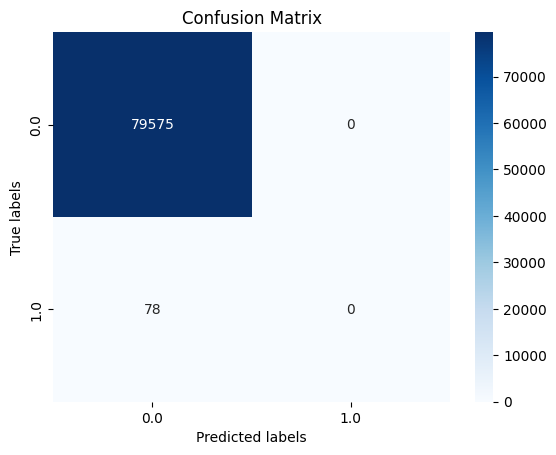

In [87]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_pred + y_test)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [88]:
y

0         0
1         0
2         0
3         0
4         0
         ..
401054    0
401055    0
401056    0
401057    0
401058    0
Name: target, Length: 398261, dtype: int64

In [89]:
df = pd.concat([clean, y], axis=1)
df.head()

,Male,Female,Torso Back,Torso Front,Left Leg,Right Leg,Left Arm,Right Arm,Head & Neck,tbp_lv_area_perim_ratio,...,tbp_lv_z,tbp_lv_Aext,tbp_lv_Hext,tbp_lv_perimeterMM,tbp_lv_x,tbp_lv_B,tbp_lv_H,age_approx,tbp_lv_symm_2axis,target
0,1,0,0,0,0,1,0,0,0,0.218652,...,0.408087,0.549700,0.267121,0.067335,0.356776,0.502444,0.508448,0.6875,0.582086,0
1,1,0,0,0,0,0,0,0,1,0.019278,...,0.571023,0.747149,0.152394,0.007756,0.504132,0.491697,0.384152,0.6875,0.252621,0
2,1,0,1,0,0,0,0,0,0,0.175593,...,0.858501,0.568489,0.336171,0.063125,0.603966,0.703178,0.566217,0.6875,0.334987,0
3,1,0,0,1,0,0,0,0,0,0.053995,...,0.572962,0.460827,0.308385,0.069412,0.390405,0.402979,0.539680,0.7500,0.170317,0
4,1,0,0,1,0,0,0,0,0,0.119577,...,0.512548,0.632028,0.230185,0.038916,0.445845,0.494130,0.451561,0.6250,0.282586,0


In [90]:
from sklearn.utils.class_weight import compute_class_weight
#Handle Class Imbalance
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)
seed = 1
neg_sample = .01
pos_sample = 5.0
# Sampling
positive_df = df.query("target==0").sample(frac=neg_sample, random_state=seed)
negative_df = df.query("target==1").sample(frac=pos_sample, replace=True, random_state=seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nClass Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Distribution Before Sampling (%):


target
0    99.902074
1     0.097926
Name: proportion, dtype: float64


Class Distribution After Sampling (%):


target
0    67.110811
1    32.889189
Name: proportion, dtype: float64

Class Weights: {0: np.float64(0.7450364413169138), 1: np.float64(1.5202564102564102)}


In [91]:
x = df.drop("target", axis=1)
y = df["target"]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [93]:
num_parallel_tree = 4
num_boost_round = 16
# total number of built trees is num_parallel_tree * num_classes * num_boost_round

dtrain = xgb.DMatrix(data=X_train, label=y_train)
booster = xgb.train({
    'num_parallel_tree': 4, 'subsample': 0.5, 'num_class': 3},
                    num_boost_round=num_boost_round, dtrain=dtrain)

In [94]:
dtest = xgb.DMatrix(X_test)
y_pred = booster.predict(dtest)
y_test = y_test.to_numpy()

In [95]:
np.mean(y_pred == y_test)

np.float64(0.9662731871838112)

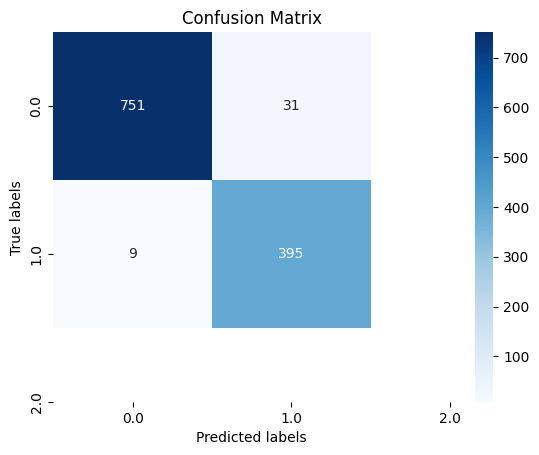

In [96]:
matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_pred + y_test)
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()